Assignment:4
1. you have to create one supervisor node.
2. create one router function
3. create three more node

    3.1. llm call (llm node)

    3.2. RAG (rag node)
    
    3.3. web crawler(fetch the info in realtime from internet)

4. created one more node after this for validation for generated output --> explore the validation part how to do that
5. if validation going to be failed in that case again go to supervioser node and then supervisor node will again decide what needs to be call next
6. once the validation will pass then only generate the final output

submission deadline till 9pm friday

submission instruction:
create your github repo and keep all the assisgnments over there(in that github repo)
i will share one googleform in group after completing your assignment you can share the github link through that google form. 

## RAG

### load docs

In [1]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader

loader=DirectoryLoader("./data2",glob="*.txt",loader_cls=TextLoader)
documents=loader.load()

In [2]:
documents[0].page_content

"ðŸ‡ºðŸ‡¸ Overview of the U.S. Economy\nThe United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services. It has a highly diversified structure with strong sectors in technology, healthcare, finance, real estate, defense, and agriculture.\n\nU.S. GDP â€“ Size, Composition, and Global Share\nAs of 2024, the United Statesâ€™ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 25% of the global economy. It ranks #1 in the world by nominal GDP, far ahead of China (which ranks 2nd). The U.S. GDP per capita is also among the high

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50,
    length_function=len,
)

In [4]:
documents=text_splitter.split_documents(documents)

### defining the embedding model

In [5]:
from dotenv import load_dotenv
load_dotenv()

True

In [6]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
len(embeddings.embed_query("Hello, world!"))

768

### Defining the llm for rag

In [7]:
from langchain.chat_models import init_chat_model

model = init_chat_model("gemini-2.0-flash", model_provider="google_genai")
model.invoke("Hello, world!")

AIMessage(content='Hello there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--8a6ff159-8739-473a-b3a7-77db3189e1b5-0', usage_metadata={'input_tokens': 4, 'output_tokens': 11, 'total_tokens': 15, 'input_token_details': {'cache_read': 0}})

In [8]:
from langchain_pinecone import PineconeVectorStore
from pinecone import ServerlessSpec
from pinecone import Pinecone
pc = Pinecone(api_key='pcsk_7iLkS_Q1viNogmFDoZMSdUK8X5YpTJZimcRGqUqzVaT83spSBfYdFQ7evD593uKhqFurE')
if pc.Index("langgraph-rag") is None:
    pc.create_index(
    name='langgraph-rag',
    dimension=768,
    metric="cosine",
    spec=ServerlessSpec(cloud="aws",region="us-east-1")    
    )

k:\Agentic ai\provided\langgraph\langgraph_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
index=pc.Index("langgraph-rag")
vector_store = PineconeVectorStore(embedding=embeddings, index=index)

In [10]:
vector_store.add_documents(documents)
vector_store.similarity_search("Usa gdp?")

[Document(id='e67f3c43-0b29-4125-ac66-40863cf5f62b', metadata={'source': 'data2\\usa.txt'}, page_content='As of 2024, the United Statesâ€™ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 25% of the global economy. It ranks #1 in the world by nominal GDP, far ahead of'),
 Document(id='954e8971-f3f5-4319-a749-45e162861427', metadata={'source': 'data2\\usa.txt'}, page_content='As of 2024, the United Statesâ€™ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 25% of the global economy. It ranks #1 in the world by nominal GDP, far ahead of'),
 Document(id='792f6998-2be7-4a44-ad14-04cece034a28', metadata={'source': 'data2\\usa.txt'}, page_content='The United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy,'),
 Document(id='c9b01d18-d099-4208-a8a6-f2fe1a6e996d', metadata={'source': 'data2

In [11]:
from langchain import hub
prompt = hub.pull("rlm/rag-prompt")

In [12]:
import pprint
pprint.pprint(prompt.messages)

[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]


In [13]:
!pip install langchain_core


[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
from langchain_core.prompts import PromptTemplate
rag_prompt=PromptTemplate(
    template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \n Answer:""",
    input_variables=['context', 'question']
)

In [15]:
def format_context(contexts):
    return "\n".join([f"Context {i+1}: {c.page_content}" for i, c in enumerate(contexts)])

In [16]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
rag_parser = StrOutputParser()

rag_chain =  {"context": vector_store.as_retriever() | format_context, "question": RunnablePassthrough()} | rag_prompt | model | rag_parser
rag_chain.invoke("usa gdp?")


"The United States' nominal GDP is estimated to be around $28 trillion USD as of 2024. This accounts for approximately 25% of the global economy. The US ranks number one in the world by nominal GDP."

In [17]:
rag_chain.invoke("What is the capital of France?")

'The provided context does not contain the answer to the question. Therefore, I do not know the answer.'

## Defining llm chain

In [18]:
from langchain_core.prompts import PromptTemplate
llm_prompt = PromptTemplate(
    template="""Anwer the follow question with you knowledge of the real world. Following is the user question:  {question}""",
    input_variables=['question']
)

In [19]:
from langchain_core.output_parsers import StrOutputParser
rag_parser = StrOutputParser()
llm_chain = llm_prompt | model | rag_parser
llm_chain.invoke("What is the capital of France?")

'Paris'

## Defining tools

In [20]:
from langchain_community.tools import DuckDuckGoSearchRun

In [21]:
!pip install -U duckduckgo-search


[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
search = DuckDuckGoSearchRun(output_format="json")
search.invoke("What is the capital of France?")

'Paris, city and capital of France, located along the Seine River, in the north-central part of the country. Paris is one of the world\'s most important and attractive cities, famed for its gastronomy, haute couture, painting, literature, and intellectual community. Learn more about Paris in this article. France\'s capital city lies in the northern part of the country. Believe it or not, it\'s actually farther north than Montreal! By high-speed train, Paris is just two-and-a-half hours from London, three hours from Brussels, and roughly two hours from Lyon or Bordeaux. There are also plenty of smaller cities nearby worth visiting, including these great day trips from Paris. Here are the capitals of the countries you asked about: France: The capital city is Paris. Who: Paris is the largest city in France and serves as the cultural and political center of the country. What: It is known for landmarks like the Eiffel Tower and the Notre-Dame Cathedral. Where: It is located in the north-cen

## Langgraph orchestration

In [23]:
from pydantic import BaseModel, Field

In [24]:
class TopicClassification(BaseModel):
    topic: str = Field(description="Selected topic")
    reasoning: str = Field(description="Reasoning for the topic selection")

In [27]:
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
import operator
class AgentState(TypedDict):
    message: Annotated[Sequence[BaseMessage],operator.add]

In [62]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
def classify_topic(state:AgentState):
    print("<<--Supervisor-->>")
    parser=PydanticOutputParser(pydantic_object=TopicClassification)
    prompt = PromptTemplate(
        template="""You are an expert in topic classification. Given a question, Classify the user query into one of the following categories:

1. RAG Node-If the query is related to USA-specific information** that is stored in your internal knowledge base (e.g., US laws, geography, culture, history, etc.)

2. Web Crawler-  If the query requires real-time, up-to-date information from the internet (e.g., current events, live scores, latest prices, recent news)

3. LLM Node-  If the query requires general reasoning, open-ended generation, or is unrelated to the USA or real-time data (e.g., coding help, creative writing, general knowledge)

Respond only with the category name:  
`RAG Node`, `Web Crawler`, or `LLM Node`.. Provide your reasoning for the classification.
Question: {question} {format_instructions}""",
        input_variables=['question'],
        partial_variables={
            "format_instructions": parser.get_format_instructions(),
        }
    )
    chain = prompt | model | parser
    response = chain.invoke({"question": state['message'][0]})
    return {"message": [response.topic]}

In [34]:
classify_topic({"message": ["What is the capital of France?"]})

{'message': ['LLM Node']}

In [84]:
def router(state: AgentState):
    print("<<--Router-->>")
    topic = classify_topic(state)
    if topic['message'][-1] == "RAG Node" or topic['message'][-1] == "Web Crawler" or topic['message'][-1] == "LLM Node":
        return topic["message"][-1]
    else:
        raise ValueError("Unknown topic classification")


In [91]:
def llm_node(state: AgentState):
    print("<<--llm-->>")
    return {'message':[llm_chain.invoke(state['message'][0])]}

In [96]:
llm_node({"message": ["Can you explain about the block chain technology?"]})

<<--llm-->>


{'message': ['Okay, here\'s an explanation of blockchain technology, drawing on real-world examples and simplified concepts:\n\n**What is Blockchain? (The Core Idea)**\n\nImagine a digital ledger, like a shared Google Sheet, that everyone in a group has access to.  Every time someone makes a change (a transaction), it\'s recorded as a "block."  This block is then linked to the previous block, creating a "chain" of records. Because everyone has a copy of the ledger, it\'s very difficult for someone to cheat or tamper with the records because everyone else would see the discrepancy.\n\n*   **Decentralized:**  Instead of being stored in one central location (like a bank\'s server), the blockchain is distributed across many computers (nodes) in a network.  This makes it more secure and resilient.\n*   **Immutable:** Once a block is added to the chain, it cannot be easily altered or deleted. This provides a high level of security and transparency.\n*   **Transparent:**  While not always rev

In [116]:
def rag_node(state: AgentState):
    print("<<--rag-->>")
    return {'message':[rag_chain.invoke(state['message'][0])]}

In [95]:
rag_node({"message": ["USA?"]})

<<--rag-->>


{'message': ['The United States of America has the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy. The U.S. GDP per capita is also among the highest, around $83,000.']}

In [93]:
def web_crawler_node(state: AgentState):
    print("<<--web-->>")
    return {'message':[search.invoke(state['message'][-1])]}

In [94]:
web_crawler_node({"message": ["What are the trending news today?"]})

<<--web-->>


{'message': ["NEW YORK (AP) — Craft labels from the now-shuttered fabrics seller Joann are making their way to a new home: Michaels. The Michaels Companies announced on Thursday that it had completed its purchase of Joann's intellectual property and private label brands — in an acquisition that arrives as the Texas-based crafting chain works to expand ... Here's a look at some of the top stories trending online today, June 10. They include the latest news on protests against ICE in California, Apples new product announcements and much more. Live updates on today's local & national top stories: politics, entertainment, sports, health & safety news with summaries, numbers, videos, and news facts. The latest breaking news stories from Forbes.com. Subscribe To Newsletters. Forbes Business Breaking News. Breaking News. 5 hours ago ... TRENDING 10 hours ago. Northern Lights Forecast: These 15 ... Reuters.com is your online source for the latest world news stories and current events, ensuring

In [117]:
from langgraph.graph import StateGraph,END

graph = StateGraph(AgentState)
graph.add_node("Supervisor", classify_topic)
graph.add_node("rag_node", rag_node)
graph.add_node("web_crawler_node", web_crawler_node)
graph.add_node("llm_node", llm_node)

In [118]:
graph.set_entry_point("Supervisor")

In [119]:
graph.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG Node": "rag_node",
        "Web Crawler": "web_crawler_node",
        "LLM Node": "llm_node"
    }
)

In [120]:
graph.add_edge("rag_node",END)
graph.add_edge("web_crawler_node",END)
graph.add_edge("llm_node",END)

In [121]:
app=graph.compile()

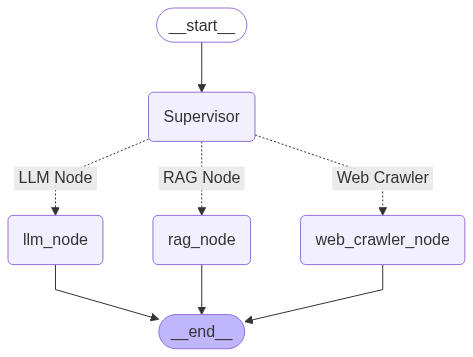

In [122]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [123]:
answer=app.invoke({"message": ["About USA?"]})

<<--Supervisor-->>
<<--Router-->>
<<--Supervisor-->>
<<--rag-->>


In [124]:
answer

{'message': ['About USA?',
  'RAG Node',
  'The United States of America has the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy. The U.S. GDP per capita is also among the highest, around $83,000.']}